# Unit 5 - Financial Planning

In [1]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation

%matplotlib inline

In [2]:
# Load .env enviroment variables
load_dotenv()

True

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [3]:
# Set current amount of crypto assets
my_btc = 1.2
my_eth = 5.3

In [4]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=CAD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=CAD"

In [5]:
# Fetch current BTC price
btc_cad_data = requests.get(btc_url)
btc_cad_json = btc_cad_data.json()
btc_cad = btc_cad_json['data']['1']['quotes']['CAD']['price']

# Fetch current ETH price
eth_cad_data = requests.get(eth_url)
eth_cad_json = eth_cad_data.json()
eth_cad = eth_cad_json['data']['1027']['quotes']['CAD']['price']

# Compute current value of my crpto
my_btc_value = my_btc*btc_cad
my_eth_value = my_eth*eth_cad

# Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is CAD {my_btc_value:0.2f}")
print(f"The current value of your {my_eth} ETH is CAD {my_eth_value:0.2f}")

The current value of your 1.2 BTC is CAD 44390.35
The current value of your 5.3 ETH is CAD 12349.74


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [6]:
# Set current amount of shares
my_agg = 200
my_spy = 50

In [7]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)

In [8]:
# Format current date as ISO format
today = pd.Timestamp("2023-03-24", tz="America/New_York").isoformat()

# Set the tickers
tickers = ["AGG", "SPY"]

# Set timeframe to "1Day" for Alpaca API
timeframe = "1Day"

# Set currency
"""
Note: The default alpaca-trade-api for python does not include a parameter
for currency specification, though the v2 api does allow for it. I've therefore
edited the rest.py file for alpaca-trade-api to include a parameter for currency
specification so that I may retrieve all stock information in CAD (for later
calculations).
"""
currency = 'CAD'

# Get current closing prices for SPY and AGG
df_shares_data = alpaca.get_bars(
    tickers,
    timeframe,
    start=today,
    end=today,
    currency=currency
).df

# Reorganize the DataFrame
# Separate ticker data
agg_data = df_shares_data[df_shares_data['symbol']=="AGG"].drop('symbol', axis=1)
spy_data = df_shares_data[df_shares_data['symbol']=="SPY"].drop('symbol', axis=1)

# Concatenate the ticker DataFrames
df_shares_data = pd.concat([agg_data, spy_data], axis=1, keys=['AGG', 'SPY'])

# Preview DataFrame
df_shares_data.head()

AGG                                              \
                             open   high     low   close   volume trade_count   
timestamp                                                                       
2023-03-24 04:00:00+00:00  137.62  137.9  137.16  137.45  6203977       23905   

                                      SPY                                    \
                             vwap    open    high     low  close     volume   
timestamp                                                                     
2023-03-24 04:00:00+00:00  137.43  537.73  543.22  534.38  543.1  107053295   

                                               
                          trade_count    vwap  
timestamp                                      
2023-03-24 04:00:00+00:00      801995  539.47

In [9]:
# Pick AGG and SPY close prices
agg_close_price = df_shares_data['AGG']['close'][0]
spy_close_price = df_shares_data['SPY']['close'][0]

# Print AGG and SPY close prices
print(f"Current AGG closing price: CAD {agg_close_price:0.2f}")
print(f"Current SPY closing price: CAD {spy_close_price:0.2f}")

Current AGG closing price: CAD 137.45
Current SPY closing price: CAD 543.10


In [10]:
# Compute the current value of shares
my_agg_value = my_agg*agg_close_price
my_spy_value = my_spy*spy_close_price

# Print current value of shares
print(f"The current value of your {my_spy} SPY shares is CAD {my_spy_value:0.2f}")
print(f"The current value of your {my_agg} AGG shares is CAD {my_agg_value:0.2f}")

The current value of your 50 SPY shares is CAD 27155.00
The current value of your 200 AGG shares is CAD 27490.00


### Savings Health Analysis

In [11]:
# Set monthly household income
monthly_income = 12000

# Consolidate financial assets data
crypto = my_btc_value+my_eth_value
shares = my_agg_value+my_spy_value
savings_data = [crypto, shares]

# Create savings DataFrame
df_savings = pd.DataFrame({'amount':savings_data}, index=['crypto', 'shares'])

# Display savings DataFrame
display(df_savings)

,amount
crypto,56740.087761
shares,54645.000000


<AxesSubplot:ylabel='Savings Distribution'>

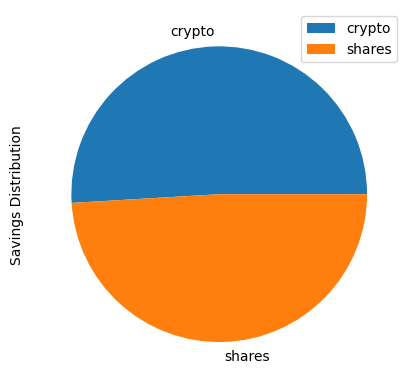

In [12]:
# Plot savings pie chart
df_savings.plot.pie(y='amount', ylabel="Savings Distribution")

In [13]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
total_savings = crypto+shares

# Validate saving health
if total_savings > emergency_fund:
    print("Congratulations! You have enough savings in this fund for an emergency situation.")
elif total_savings == emergency_fund:
    print("Congratulations on reaching your emergency savings goal!")
else:
    print(f"You are ${emergency_fund-total_savings:0.2f} away from reaching your emergency savings goal.")

Congratulations! You have enough savings in this fund for an emergency situation.


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [14]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
start_date = pd.Timestamp('2018-03-24', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2023-03-24', tz='America/New_York').isoformat()

In [15]:
# Get 5 years' worth of historical data for SPY and AGG
df_stock_data = alpaca.get_bars(
    tickers,
    timeframe,
    start=start_date,
    end=end_date,
    currency=currency
).df

# Reorganize the DataFrame
# Separate ticker data
agg_historical_data = df_stock_data[df_stock_data['symbol']=="AGG"].drop('symbol', axis=1)
spy_historical_data = df_stock_data[df_stock_data['symbol']=="SPY"].drop('symbol', axis=1)

# Concatenate the ticker DataFrames
df_stock_data = pd.concat([agg_historical_data, spy_historical_data], axis=1, keys=['AGG', 'SPY'])

# Display sample data
df_stock_data.head()

AGG                                   \
                             open    high     low   close   volume   
timestamp                                                            
2018-03-26 04:00:00+00:00  137.21  137.30  136.99  137.12  4546535   
2018-03-27 04:00:00+00:00  136.82  137.23  136.79  137.14  4566884   
2018-03-28 04:00:00+00:00  137.81  137.87  137.59  137.67  5617206   
2018-03-29 04:00:00+00:00  138.16  138.56  138.16  138.55  9199453   
2018-04-02 04:00:00+00:00  137.82  138.00  137.72  137.82  7280259   

                                                  SPY                          \
                          trade_count    vwap    open    high     low   close   
timestamp                                                                       
2018-03-26 04:00:00+00:00       19722  137.14  337.28  341.52  333.78  341.15   
2018-03-27 04:00:00+00:00       14293  137.07  341.53  342.30  332.12  334.59   
2018-03-28 04:00:00+00:00       18689  137.72  335.67  338.10  332.88  334.51   
2018-03-29 04:00:00+00:00       20364  138.50  337.32  342.67  335.67  340.30   
2018-04-02 04:00:00+00:00       24906  137.86  338.49  339.24  328.33  332.01   

                                                          
                              volume trade_count    vwap  
timestamp                                                 
2018-03-26 04:00:00+00:00  143141239      450168  337.56  
2018-03-27 04:00:00+00:00  130806695      538201  337.65  
2018-03-28 04:00:00+00:00  146510333      590467  335.21  
2018-03-29 04:00:00+00:00  125470572      436558  339.54  
2018-04-02 04:00:00+00:00  186324337      643544  332.90

In [16]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
num_sims = 500
num_days = 252*30
weights = [0.4, 0.6]

mc_stocks = MCSimulation(
    portfolio_data=df_stock_data,
    weights=weights,
    num_simulation=num_sims,
    num_trading_days=num_days
)

In [17]:
# Printing the simulation input data
print(f"Portfolio sample data: {df_stock_data.head()}")
print(f"Bonds/stocks weighting: {weights[0]*100}%/{weights[1]*100}%")
print(f"Number of simulations: {num_sims}")
print(f"Number of trading days: {num_days}")

Portfolio sample data:                               AGG                                   \
                             open    high     low   close   volume   
timestamp                                                            
2018-03-26 04:00:00+00:00  137.21  137.30  136.99  137.12  4546535   
2018-03-27 04:00:00+00:00  136.82  137.23  136.79  137.14  4566884   
2018-03-28 04:00:00+00:00  137.81  137.87  137.59  137.67  5617206   
2018-03-29 04:00:00+00:00  138.16  138.56  138.16  138.55  9199453   
2018-04-02 04:00:00+00:00  137.82  138.00  137.72  137.82  7280259   

                                                  SPY                          \
                          trade_count    vwap    open    high     low   close   
timestamp                                                                       
2018-03-26 04:00:00+00:00       19722  137.14  337.28  341.52  333.78  341.15   
2018-03-27 04:00:00+00:00       14293  137.07  341.53  342.30  332.12  334.59   
2018-03-28 

In [18]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
mc_stocks.calc_cumulative_return() 

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


C:\Users\Julian\Documents\FinTech\Module 5\apis-homework\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.997451,0.994692,1.008613,0.990356,0.983731,0.991337,0.998173,0.977989,1.007455,1.008822,...,1.006930,0.987431,1.015628,1.011505,1.010930,0.995618,1.003925,1.002692,1.006627,1.008671
2,0.991556,0.995697,1.005261,0.989248,0.989725,0.988518,0.991774,0.975909,1.000658,1.018095,...,0.988583,1.000755,1.027707,1.015353,1.013624,1.003782,1.002546,0.993573,1.018533,1.005078
3,0.980527,1.006854,1.010123,0.987726,1.001945,0.986048,1.002007,0.991220,0.998455,1.017647,...,0.993613,1.008646,1.025893,1.029772,1.016758,1.007379,0.994518,1.002391,1.017180,1.007307
4,0.988670,1.021189,0.994561,0.987023,1.011435,0.998673,0.998461,0.994659,0.997198,1.004308,...,0.987027,1.018092,1.023037,1.036799,1.005001,1.005898,0.995335,1.005917,1.033388,1.017357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,1.311376,4.428844,15.097744,3.506075,8.132133,1.771606,4.924825,4.714934,2.096651,15.502836,...,2.022135,13.710470,11.913721,3.245422,6.009682,11.901991,13.456173,9.273958,29.135189,4.874685
7557,1.305037,4.398313,14.825181,3.516074,8.123587,1.754465,4.953075,4.717333,2.072202,15.523324,...,2.043726,13.738364,11.787479,3.234641,6.016519,11.862085,13.544567,9.104134,29.367580,4.815282
7558,1.291310,4.419843,14.804781,3.515790,8.134020,1.759141,5.016595,4.677857,2.075439,15.698699,...,2.035513,13.667815,11.768909,3.251023,6.076138,11.976053,13.719244,9.183436,29.474634,4.799827
7559,1.298987,4.394822,14.748061,3.494099,8.130085,1.747023,4.981425,4.687445,2.103477,15.775497,...,2.033865,13.577441,11.780539,3.276098,6.137486,12.114932,13.762516,9.321563,29.056867,4.771353


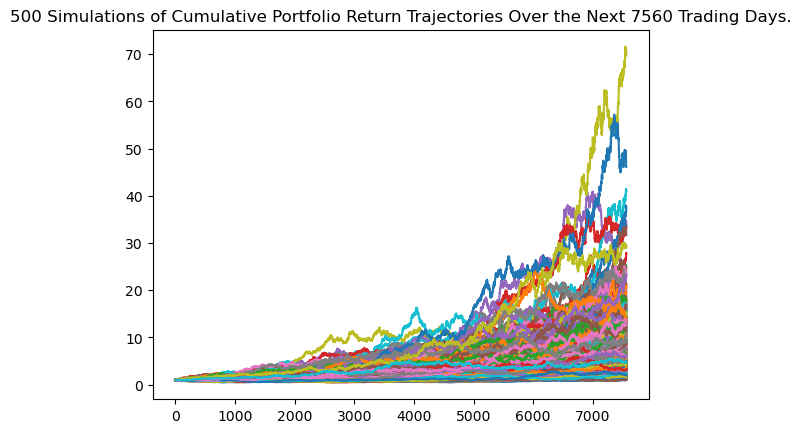

In [19]:
# Plot simulation outcomes
sim_line_plot = mc_stocks.plot_simulation()

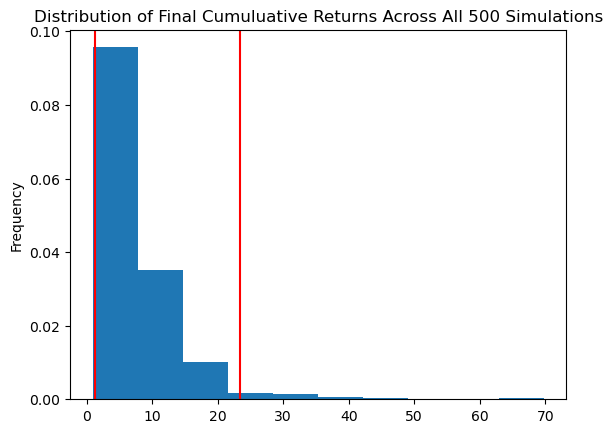

In [20]:
# Plot probability distribution and confidence intervals
sim_dist_plot = mc_stocks.plot_distribution()

### Retirement Analysis

In [21]:
# Fetch summary statistics from the Monte Carlo simulation results
sim_summary_stats = mc_stocks.summarize_cumulative_return()

# Print summary statistics
print(sim_summary_stats)

count           500.000000
mean              7.822769
std               6.583491
min               0.962321
25%               3.929098
50%               6.035381
75%               9.968032
max              69.744874
95% CI Lower      1.356140
95% CI Upper     23.476738
Name: 7560, dtype: float64


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `$20,000` initial investment.

In [22]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower = round(sim_summary_stats[8]*initial_investment, 2)
ci_upper = round(sim_summary_stats[9]*initial_investment, 2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $27122.8 and $469534.75


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [23]:
# Set initial investment
initial_investment = 20000*1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower = round(sim_summary_stats[8]*initial_investment, 2)
ci_upper = round(sim_summary_stats[9]*initial_investment, 2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $40684.2 and $704302.13


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [24]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
num_sims_five = 500
num_days_five = 252*5
weights_five = [0.1, 0.9]

mc_stocks_five = MCSimulation(
    portfolio_data=df_stock_data,
    weights=weights_five,
    num_simulation=num_sims_five,
    num_trading_days=num_days_five
)

In [25]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
mc_stocks_five.calc_cumulative_return() 

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


C:\Users\Julian\Documents\FinTech\Module 5\apis-homework\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.996780,1.012576,0.993109,0.993436,1.004923,0.988308,0.997575,0.991123,1.003162,1.002613,...,1.002077,0.998336,0.990063,0.997044,1.020754,0.975697,1.014683,0.995836,1.002708,0.996965
2,1.008894,1.000301,0.991208,0.974004,0.999122,0.997503,0.988248,0.996344,1.007094,1.015453,...,1.009287,1.010141,0.980146,0.970506,1.005613,0.981462,0.994182,0.998345,1.025286,0.990780
3,0.987381,1.017166,1.009676,0.997312,0.987122,0.998746,0.987420,1.005169,0.994836,1.025537,...,1.025508,0.997710,0.993151,0.965563,1.006780,0.981389,0.996105,1.000740,1.018455,1.008597
4,0.997496,0.995298,0.997276,0.977516,1.000528,1.008080,0.991973,0.998783,0.981644,1.036444,...,1.054257,1.014034,1.002176,0.972880,0.994882,0.975173,0.980616,0.980371,1.027490,1.017936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.440129,0.888258,1.330773,2.869355,0.817457,2.373439,1.182426,2.317842,0.763505,1.105645,...,1.035223,1.688431,0.967353,0.963551,1.003895,2.828684,1.046455,0.549588,2.823457,1.667336
1257,1.417836,0.879878,1.329067,2.935073,0.830214,2.356034,1.193407,2.292623,0.757097,1.107866,...,1.053148,1.715633,0.942339,0.942753,1.007470,2.803975,1.035117,0.547385,2.832608,1.682273
1258,1.391463,0.868439,1.334389,2.923863,0.841339,2.386141,1.168981,2.313558,0.739661,1.115031,...,1.083702,1.707156,0.933623,0.956412,1.001298,2.783611,1.056190,0.549435,2.846242,1.681994
1259,1.385183,0.882155,1.325299,2.953535,0.843832,2.388342,1.182748,2.293469,0.747923,1.116557,...,1.078560,1.716205,0.934033,0.965161,1.011520,2.780412,1.041273,0.543292,2.825954,1.661761


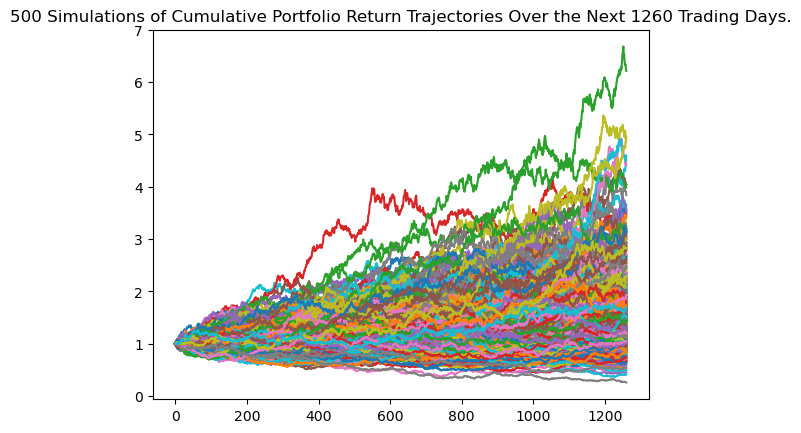

In [26]:
# Plot simulation outcomes
sim_line_plot_five = mc_stocks_five.plot_simulation()

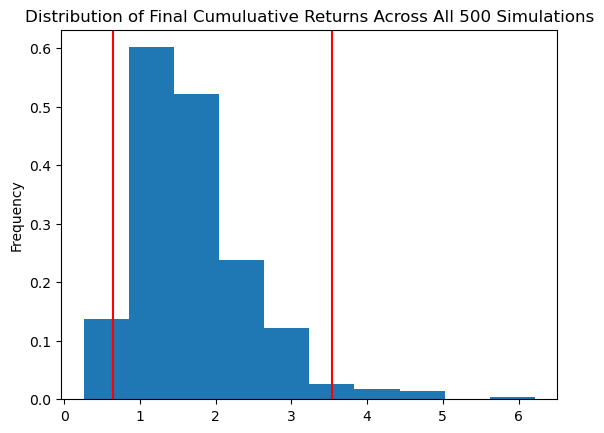

In [27]:
# Plot probability distribution and confidence intervals
sim_dist_plot_five = mc_stocks_five.plot_distribution()

In [28]:
# Fetch summary statistics from the Monte Carlo simulation results
sim_summary_stats_five = mc_stocks_five.summarize_cumulative_return()

# Print summary statistics
print(sim_summary_stats_five)

count           500.000000
mean              1.675219
std               0.777546
min               0.259931
25%               1.093251
50%               1.536386
75%               2.044980
max               6.214769
95% CI Lower      0.648104
95% CI Upper      3.532156
Name: 1260, dtype: float64


In [29]:
# Set initial investment
initial_investment = 60000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_five = round(sim_summary_stats_five[8]*initial_investment, 2)
ci_upper_five = round(sim_summary_stats_five[9]*initial_investment, 2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five} and ${ci_upper_five}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 5 years will end within in the range of $38886.23 and $211929.33


### Ten Years Retirement Option

In [30]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
num_sims_ten = 500
num_days_ten = 252*10
weights_ten = [0.1, 0.9]

mc_stocks_ten = MCSimulation(
    portfolio_data=df_stock_data,
    weights=weights_ten,
    num_simulation=num_sims_ten,
    num_trading_days=num_days_ten
)

In [31]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
mc_stocks_ten.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


C:\Users\Julian\Documents\FinTech\Module 5\apis-homework\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.981704,0.984428,0.992161,1.003117,0.989413,1.011968,0.983351,0.989091,0.997611,0.998138,...,0.994286,1.036968,0.995332,1.006367,1.005474,1.000495,1.009091,1.002726,0.974487,1.006096
2,1.002578,0.995003,1.017948,0.981172,0.995198,1.008105,0.997872,0.981345,0.999062,1.020737,...,0.973952,1.037930,0.990528,1.001691,0.994969,0.974939,1.022741,1.015596,0.961571,1.012393
3,0.987209,1.026205,1.021965,0.981562,1.008255,1.010771,1.005480,0.988353,1.010985,1.027362,...,0.974919,1.039586,0.991546,1.024799,1.005469,0.979053,1.044193,1.040396,0.951899,1.030408
4,0.994494,1.025775,1.040623,0.988414,1.003041,1.003060,1.003384,0.971802,1.022365,1.024620,...,0.978813,1.034563,1.013258,1.024785,1.020022,0.984791,1.044126,1.081211,0.943855,1.040019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,3.666908,2.378147,2.159252,3.669023,3.619270,2.147036,1.610995,2.952342,1.590626,0.630799,...,1.872895,16.648462,1.668074,1.794557,2.338055,4.130733,2.143649,3.098999,1.036619,1.939170
2517,3.659878,2.359287,2.111907,3.723931,3.557054,2.160412,1.588637,2.976641,1.592097,0.628735,...,1.899994,16.450487,1.664521,1.807325,2.348018,4.154258,2.144811,3.058258,1.042571,1.947413
2518,3.599657,2.351301,2.080950,3.848100,3.629258,2.191642,1.600078,3.008243,1.566661,0.631554,...,1.902742,16.718627,1.665382,1.804692,2.343718,4.128528,2.133819,3.012213,1.062099,1.926996
2519,3.645596,2.295329,2.088331,3.789368,3.664034,2.184799,1.600412,3.034667,1.568841,0.618906,...,1.914195,16.620942,1.693681,1.795489,2.345904,4.132003,2.175673,3.067992,1.080668,1.941283


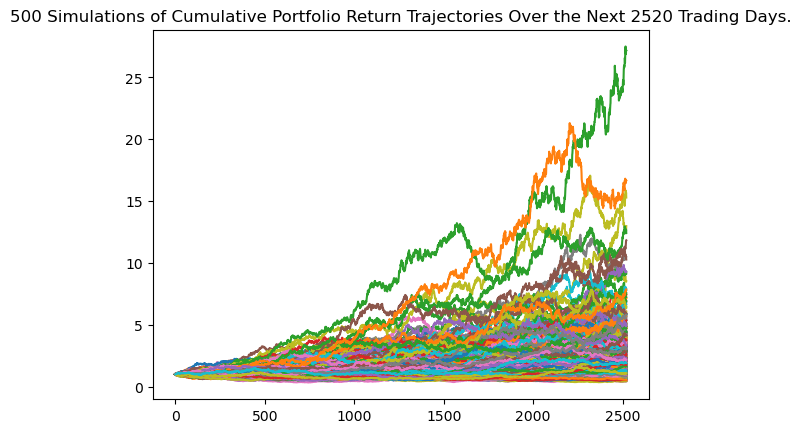

In [32]:
# Plot simulation outcomes
sim_line_plot_ten = mc_stocks_ten.plot_simulation()

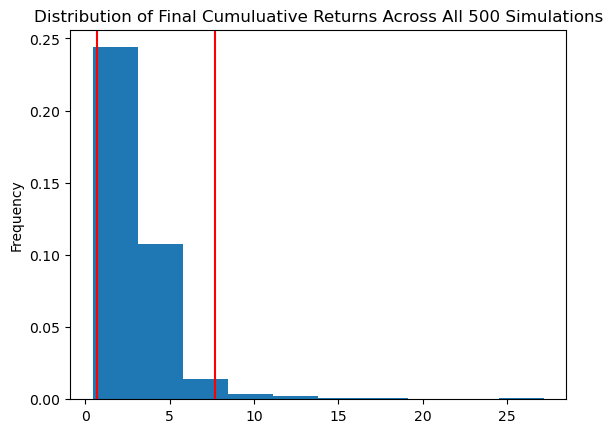

In [33]:
# Plot probability distribution and confidence intervals
sim_dist_plot_ten = mc_stocks_ten.plot_distribution()

In [34]:
# Fetch summary statistics from the Monte Carlo simulation results
sim_summary_stats_ten = mc_stocks_ten.summarize_cumulative_return()

# Print summary statistics
print(sim_summary_stats_ten)

count           500.000000
mean              2.865427
std               2.223307
min               0.441820
25%               1.579455
50%               2.329432
75%               3.473945
max              27.180989
95% CI Lower      0.713379
95% CI Upper      7.693068
Name: 2520, dtype: float64


In [35]:
# Set initial investment
initial_investment = 60000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_ten = round(sim_summary_stats_ten[8]*initial_investment, 2)
ci_upper_ten = round(sim_summary_stats_ten[9]*initial_investment, 2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_ten} and ${ci_upper_ten}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 10 years will end within in the range of $42802.74 and $461584.05
